In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
import pickle, datetime
from scipy.stats import norm, beta, gamma
from scipy.stats import pearsonr
from tqdm import tqdm

In [3]:
import sys
sys.path.append('../')
from pyEM.fitting import EMfit
from pyEM.math import norm2alpha, norm2beta, alpha2norm, beta2norm, compGauss_ms
from pyEM import plotting
import rw_models
import joblib

# Simulation behavior check

In [4]:
# load 4 models simulated data
sim_basic = pd.read_csv('../data/simulated_basic.csv')
sim_context = pd.read_csv('../data/simulated_context.csv')
sim_outcome = pd.read_csv('../data/simulated_outcome.csv')
sim_valence = pd.read_csv('../data/simulated_valence.csv')

est_sim_context = pd.read_csv('../data/estimated_recovery_context.csv')

In [5]:
# make a function to map blocks to block_type and sort as categorical
def block_type(df):
    df['block_type'] = df['blocks'].map({'numberbar_pos':'reward', 'numberbar_mixed':'mix', 'numberbar_neg':'punishment'})
    df['block_type'] = pd.Categorical(df['block_type'], categories=['punishment', 'mix', 'reward'])
    df['optimal_L'] = df['opt_act'].map({0:1, 1:0})
    # compute the optimal action if choice_L == optimal_L (1) or not (0)
    df['optimal'] = (df['optimal_L'] == df['choices_L']).astype(int)
    return df

sim_basic = block_type(sim_basic)
sim_context = block_type(sim_context)
sim_outcome = block_type(sim_outcome)
sim_valence = block_type(sim_valence)
est_sim_context = block_type(est_sim_context)

# Parameter recovery

In [6]:
# def plot_param_recovery(param_names, df, mod):
#     sns.set_context('talk')
    
#     # Step 1: Dynamically adjust the number of subplots based on the length of param_names
#     num_params = len(param_names)
#     fig, ax = plt.subplots(1, num_params, figsize=(15, 5))
    
#     # Handle case where ax is a single object (if num_params = 1)
#     if num_params == 1:
#         ax = [ax]
    
#     # Panel labels (a, b, c, d)
#     panel_labels = ['a', 'b', 'c', 'd']
    
#     for idx, param in enumerate(param_names):
#         sns.scatterplot(data=df, x=f'{param}_sim', y=param, ax=ax[idx], color='grey', alpha=0.5)
#         sns.regplot(data=df, x=f'{param}_sim', y=param, ax=ax[idx], color='black', scatter=False)
        
#         # Calculate Pearson correlation and add to plot
#         r, _ = pearsonr(df[param], df[f'{param}_sim'])
#         ax[idx].text(0.05, 0.95, f'Pearson r = {r:.2f}', transform=ax[idx].transAxes, fontsize=12, verticalalignment='top')
        
#         # Set axis labels and title
#         ax[idx].set_xlabel('Simulated')
#         ax[idx].set_ylabel('Estimated')
#         ax[idx].set_title(param)
        
#         # Add panel label (e.g., a, b, c, d)
#         ax[idx].text(-0.1, 1.15, panel_labels[idx], transform=ax[idx].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

#     # Add model name as title
#     fig.suptitle(mod, fontsize=16)
#     sns.despine()
#     plt.tight_layout()
#     plt.show()


In [7]:
# make above plotting as function taking param_names and dataframe as inpute
def plot_param_recovery(param_names, df, mod):
    sns.set_context('talk')
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    # Panel labels (a, b, c, d)
    panel_labels = ['a', 'b', 'c', 'd']
    for idx, param in enumerate(param_names):
        sns.scatterplot(data=df, x=f'{param}_sim', y=param, ax=ax[idx], color='grey', alpha=0.5)
        sns.regplot(data=df, x=f'{param}_sim', y=param, ax=ax[idx], color='black', scatter=False, ci=95)
        r, _ = pearsonr(df[param], df[f'{param}_sim'])
        ax[idx].text(0.05, 0.95, f'Pearson r = {r:.2f}', transform=ax[idx].transAxes, fontsize=12, verticalalignment='top')
        ax[idx].set_xlabel('simulated')
        ax[idx].set_ylabel('estimated')
        ax[idx].set_title(param)

        # Add panel label (e.g., a, b, c, d)
        ax[idx].text(-0.1, 1.15, panel_labels[idx], transform=ax[idx].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    # add model name as title
    fig.suptitle(mod)
    sns.despine()
    plt.tight_layout()
    plt.show()

In [20]:
mod = 'context_est'

if mod == 'basic':
    param_names = ['alpha', 'beta'] # basic
    recov_df    = sim_basic
elif mod == 'valence':
    param_names = ['alpha_pos', 'alpha_neg', 'beta'] # valence
    recov_df    = sim_valence
elif mod == 'outcome':
    param_names = ['alpha_rew', 'alpha_pun', 'beta'] # outcome
    recov_df    = sim_outcome
elif mod == 'context':
    param_names = ['alpha_opt', 'alpha_pes', 'alpha_mix', 'beta'] # context
    recov_df    = sim_context
elif mod == 'context_est':
    param_names = ['alpha_opt', 'alpha_pes', 'alpha_mix', 'beta']
    recov_df    = est_sim_context

In [21]:
# take the first row per subject
recov_df = recov_df.groupby('subject').first().reset_index()
recov_df.head()

,subject,block,trial,choices,choices_L,outcomes,opt_act,blocks,pe,choice_nll,...,BICint,LME,alpha_opt_sim,alpha_pes_sim,alpha_mix_sim,beta_sim,model,block_type,optimal_L,optimal
0,0,0,0,1,0.0,1.0,1.0,numberbar_mixed,1.0,0.5,...,19770.028867,-9920.242495,0.774725,0.752628,0.738215,3.021878,sim_context,mix,0,1
1,1,0,0,1,0.0,1.0,1.0,numberbar_mixed,1.0,0.5,...,19770.028867,-9920.242495,0.804361,0.728903,0.284589,2.145853,sim_context,mix,0,1
2,2,0,0,1,0.0,1.0,1.0,numberbar_mixed,1.0,0.5,...,19770.028867,-9920.242495,0.777013,0.742968,0.455163,1.782706,sim_context,mix,0,1
3,3,0,0,0,1.0,-1.0,1.0,numberbar_mixed,-1.0,0.5,...,19770.028867,-9920.242495,0.757528,0.641182,0.791698,3.241143,sim_context,mix,0,0
4,4,0,0,0,1.0,-1.0,1.0,numberbar_mixed,-1.0,0.5,...,19770.028867,-9920.242495,0.774386,0.770077,0.759115,3.190922,sim_context,mix,0,0


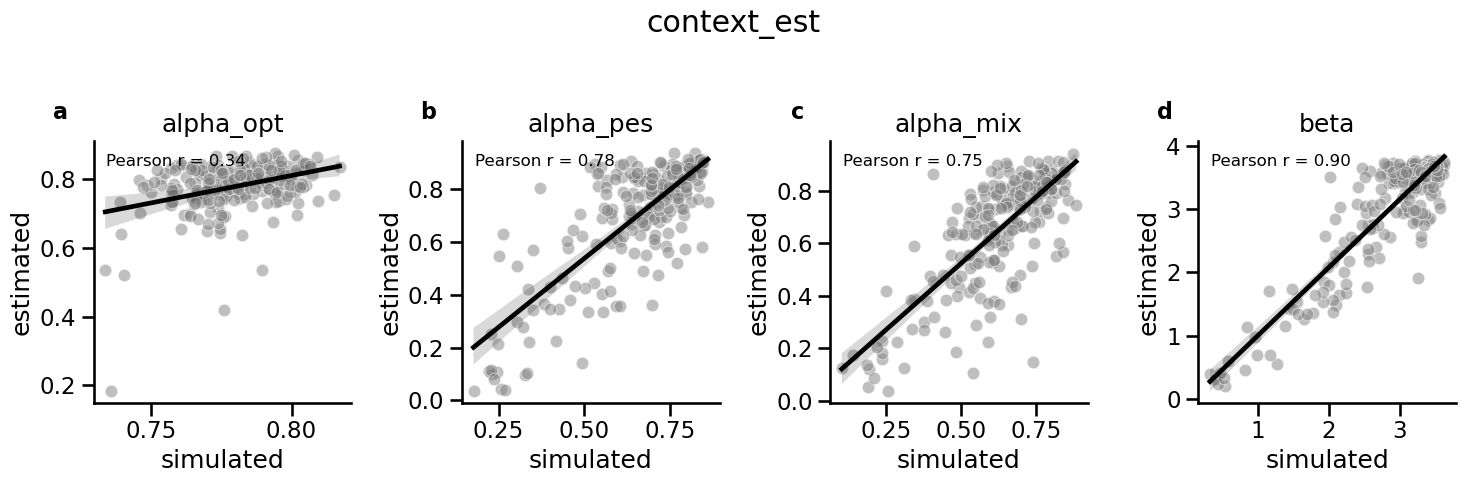

In [22]:
plot_param_recovery(param_names, recov_df, mod)

# Simulated behavior visualization

In [55]:
# make the above plottings into a function
def plot_subject(sub_df, subject, model):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    for i, ax in enumerate(axs):
        block_df = sub_df[sub_df['block']==i]
        ax.plot(block_df['trial'], block_df['choices_L'], 'o')
        ax.plot(block_df['trial'], block_df['optimal_L'], '-')
        ax.set_title(block_df['block_type'].iloc[0])
        ax.set_xlabel('Trial')
        ax.set_ylabel('Choice (Left)')

        # block optimal mean
        opt_mean = block_df['optimal'].mean()
        ax.axhline(opt_mean, color='black', linestyle='--')
        ax.axhline(y=0.5, color='black', linestyle='-')
    
    axs[-1].legend(['Choice', 'Optimal (Left)'])
    plt.suptitle(f'Subject {subject} - {model["model"][0]}')

In [56]:
# randomly select a subject to visualize simulated data
subject = np.random.randint(0, 219)
mod = sim_basic  

sub_df = mod[mod['subject']==subject]
sub_df['trial'] += 1
sub_df.head()

c:\Users\fuq01\AppData\Local\anaconda3\envs\emfit\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,subject,block,trial,choices,choices_L,outcomes,opt_act,blocks,pe,choice_nll,alpha,beta,ev_l,ev_r,alpha_sim,beta_sim,model,block_type,optimal_L,optimal
7665,73,0,1,1,0.0,1.0,1.0,numberbar_mixed,1.000000,0.500000,0.083295,1.222352,0.000000,0.000000,0.272305,1.139061,sim_basic,mix,0,1
7666,73,0,2,0,1.0,1.0,1.0,numberbar_mixed,1.000000,0.474568,0.083295,1.222352,0.000000,0.083295,0.272305,1.139061,sim_basic,mix,0,0
7667,73,0,3,1,0.0,1.0,1.0,numberbar_mixed,0.916705,0.500000,0.083295,1.222352,0.083295,0.083295,0.272305,1.139061,sim_basic,mix,0,1
7668,73,0,4,0,1.0,-1.0,1.0,numberbar_mixed,-1.083295,0.476683,0.083295,1.222352,0.083295,0.159652,0.272305,1.139061,sim_basic,mix,0,0
7669,73,0,5,0,1.0,-1.0,1.0,numberbar_mixed,-0.993062,0.449267,0.083295,1.222352,-0.006938,0.159652,0.272305,1.139061,sim_basic,mix,0,0


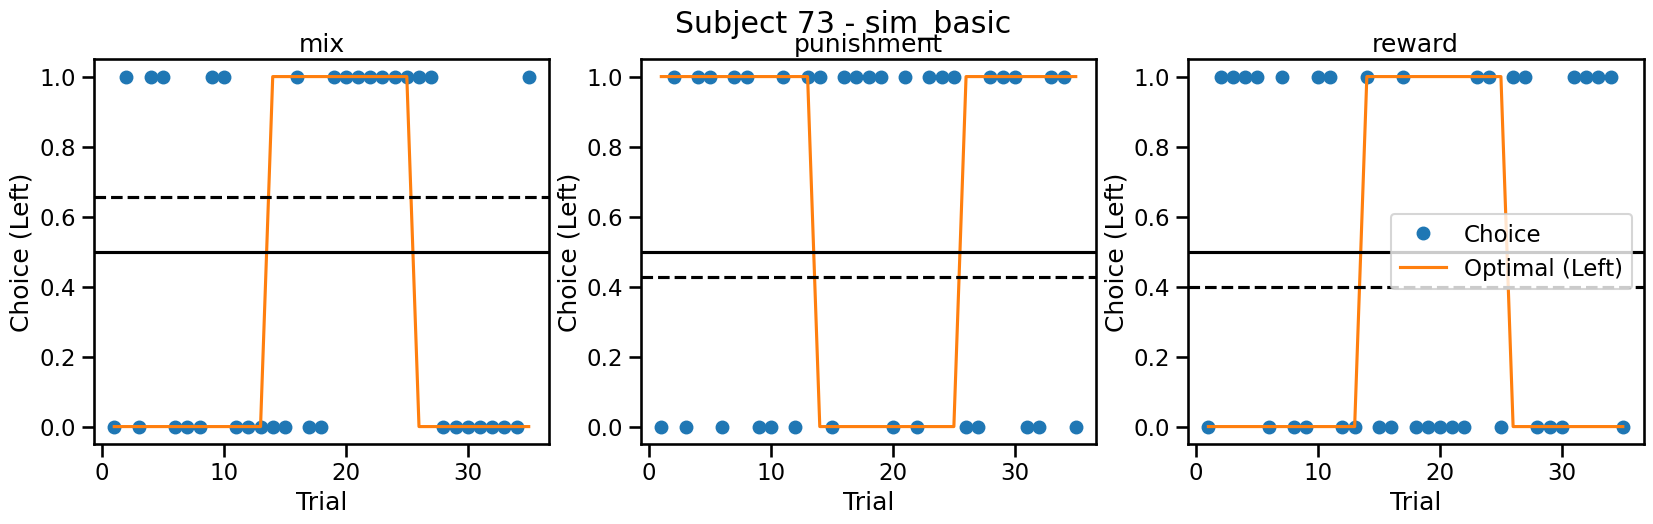

In [57]:
plot_subject(sub_df, subject, mod)

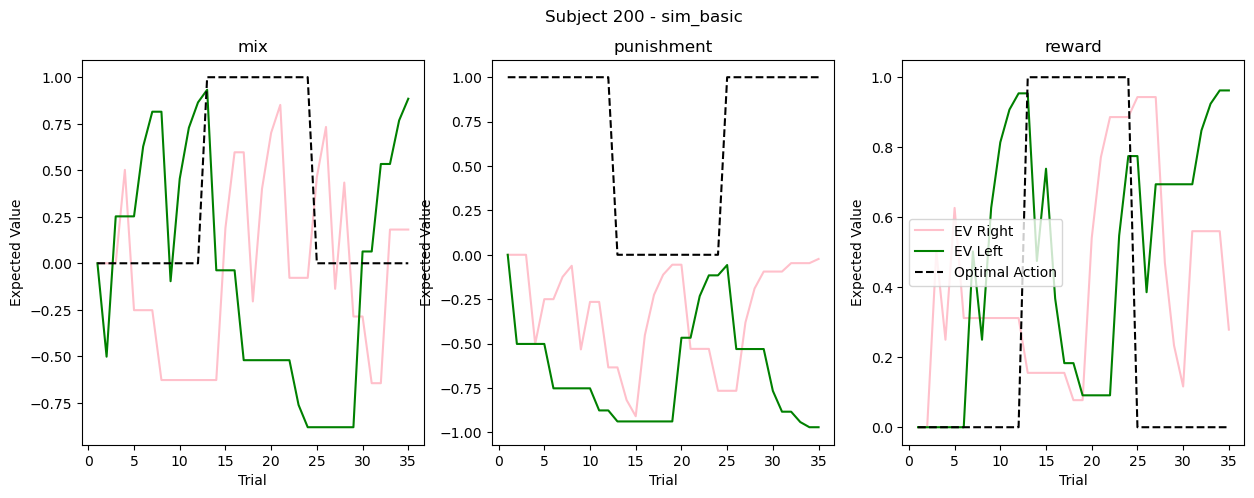

In [9]:
# plot ev_l and ev_r for a subject
def plot_ev(sub_df, subject, model):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axs):
        block_df = sub_df[sub_df['block']==i]
        ax.plot(block_df['trial'], block_df['ev_r'], '-', color='pink')
        ax.plot(block_df['trial'], block_df['ev_l'], '-', color='green')
        ax.plot(block_df['trial'], block_df['opt_act'], '--', color='black')
        ax.set_title(block_df['block_type'].iloc[0])
        ax.set_xlabel('Trial')
        ax.set_ylabel('Expected Value')
    
    axs[-1].legend(['EV Right', 'EV Left', 'Optimal Action'])
    plt.suptitle(f'Subject {subject} - {model["model"][0]}')

plot_ev(sub_df, subject, mod)

In [10]:
def plot_optimal(sim_df):
    sim_sub_level = sim_df.groupby(['subject', 'block_type'])['optimal'].mean().reset_index()
    sns.boxplot(data=sim_sub_level, x='block_type', y='optimal')
    sns.lineplot(data=sim_sub_level, x='block_type', y='optimal', color='red', errorbar=('se', 1))
    plt.axhline(0.5, color='black', linestyle='-')
    plt.xlabel('block')
    plt.title(sim_df['model'][0])
    sns.despine()

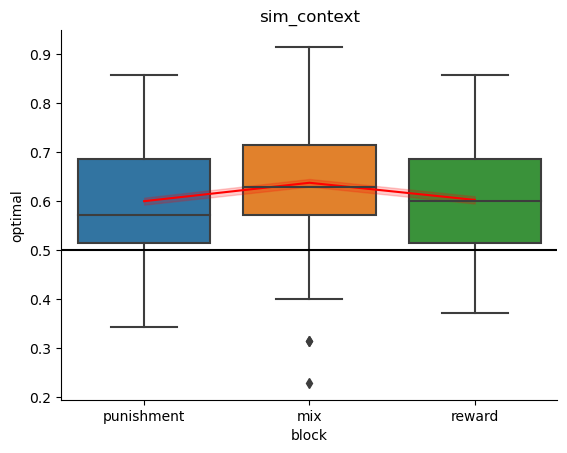

In [31]:
plot_optimal(sim_context)

In [21]:
# visualize optimal choice as a function of learning rate
def plot_optimal_lr(sim_df, param):
    sim_sub_level = sim_df.groupby(['subject', 'block_type', param])['optimal'].mean().reset_index()
    sns.lineplot(data=sim_sub_level, x=param, y='optimal', hue='block_type', errorbar=('se',1))
    plt.axhline(0.5, color='black', linestyle='-')
    plt.xlabel(param)
    plt.title(sim_df['model'][0])
    sns.despine()

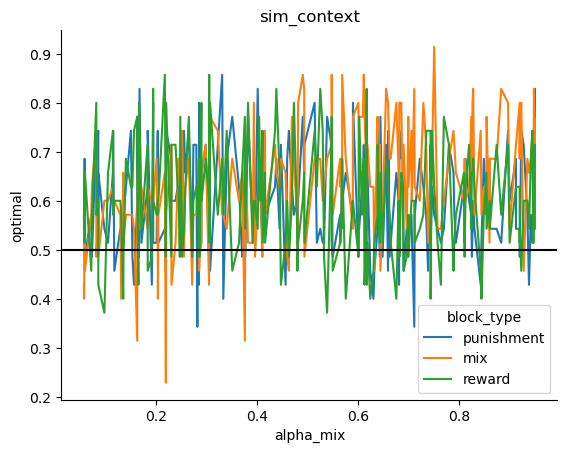

In [34]:
plot_optimal_lr(sim_context, 'alpha_mix')

In [114]:
# Specific sequence to match
mod_df = sim_basic

target_sequence = mod_df['opt_act'][0:35].to_list()
grouped = mod_df.groupby(['subject', 'block'])

# Define a function to check if a block matches the target sequence
def match_sequence(group):
    # Sort by trial if necessary
    group_sorted = group.sort_values(by='trial')
    # Check if the 'optimal_sequence' column matches the target sequence
    return np.array_equal(group_sorted['opt_act'].values, target_sequence)

# Apply the filtering function to each group and filter only matching groups
matching_reversal = grouped.filter(match_sequence)
matching_reversal

,subject,block,trial,choices,choices_L,outcomes,opt_act,blocks,pe,choice_nll,...,ch_prob_l,ch_prob_r,BICint,LME,alpha_sim,beta_sim,model,block_type,optimal_L,optimal
0,0,0,0,1,0.0,1.0,1.0,numberbar_mixed,1.000000,0.500000,...,0.2,0.8,5829.40774,-2922.403901,0.876886,2.106523,sim_basic,mix,0,1
1,0,0,1,1,0.0,1.0,1.0,numberbar_mixed,0.059900,0.874842,...,0.2,0.8,5829.40774,-2922.403901,0.876886,2.106523,sim_basic,mix,0,1
2,0,0,2,1,0.0,1.0,1.0,numberbar_mixed,0.003588,0.887048,...,0.2,0.8,5829.40774,-2922.403901,0.876886,2.106523,sim_basic,mix,0,1
3,0,0,3,1,0.0,1.0,1.0,numberbar_mixed,0.000215,0.887745,...,0.2,0.8,5829.40774,-2922.403901,0.876886,2.106523,sim_basic,mix,0,1
4,0,0,4,0,1.0,1.0,1.0,numberbar_mixed,1.000000,0.112213,...,0.2,0.8,5829.40774,-2922.403901,0.876886,2.106523,sim_basic,mix,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,48,1,30,1,0.0,0.0,1.0,numberbar_neg,0.329777,0.650414,...,0.2,0.8,5829.40774,-2922.403901,0.265754,1.103107,sim_basic,punishment,0,1
5106,48,1,31,1,0.0,0.0,1.0,numberbar_neg,0.229128,0.677460,...,0.2,0.8,5829.40774,-2922.403901,0.265754,1.103107,sim_basic,punishment,0,1
5107,48,1,32,0,1.0,-1.0,1.0,numberbar_neg,-0.154919,0.304411,...,0.2,0.8,5829.40774,-2922.403901,0.265754,1.103107,sim_basic,punishment,0,0
5108,48,1,33,1,0.0,0.0,1.0,numberbar_neg,0.159198,0.707515,...,0.2,0.8,5829.40774,-2922.403901,0.265754,1.103107,sim_basic,punishment,0,1


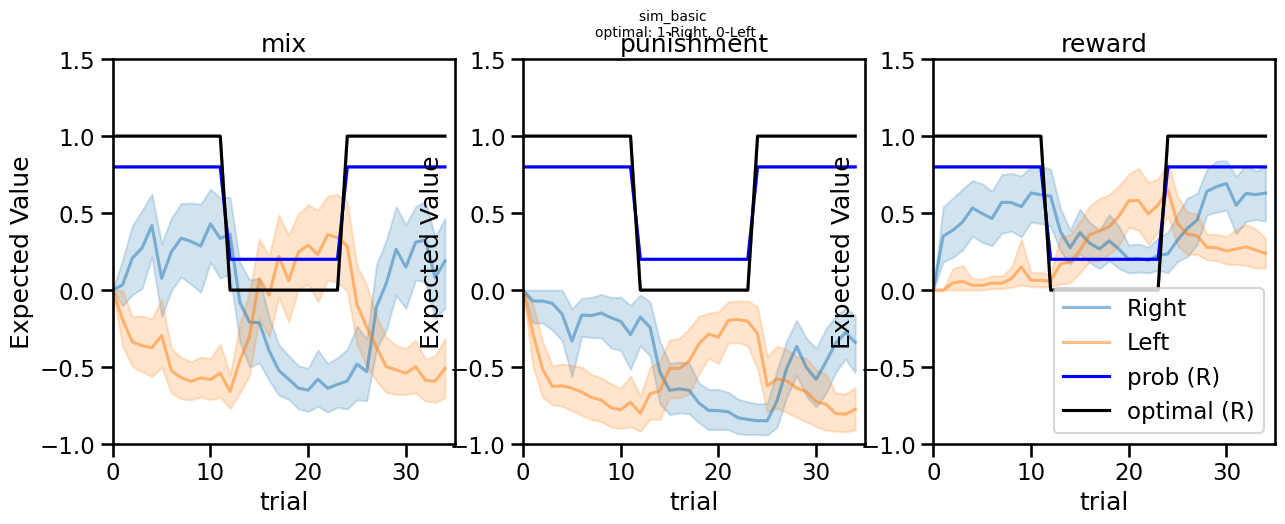

In [118]:
# make the above plot to loop through all blocks in subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, b in enumerate(matching_reversal['block_type'].unique()):    
    df_block = matching_reversal[matching_reversal.block_type == b]
    sns.lineplot(data=df_block, x='trial', y='ev_r', legend=False, alpha=0.5, label='Right', ax=ax[i])
    sns.lineplot(data=df_block, x='trial', y='ev_l', legend=False, alpha=0.5, label='Left', ax=ax[i])
    sns.lineplot(data=df_block, x='trial', y='ch_prob_r', legend=False, label='prob (R)', color='blue', ax=ax[i])

    # sns.scatterplot(data=df_block, x='trial', y='choices', marker='o', s=10, color='blue', ax=ax[i])

    sns.lineplot(data=df_block, x='trial', y='opt_act', legend=False, label='optimal (R)', color='black', ax=ax[i])
    ax[i].set_ylabel('Expected Value')
    ax[i].set_title(b)
    ax[i].set_ylim(-1, 1.5)
    ax[i].set_xlim(0, 35)

mod_name = matching_reversal['model'][0]
plt.suptitle(f'{mod_name} \noptimal: 1-Right, 0-Left', fontsize=10)
plt.legend()

In [102]:
# plot outcome as scatter across blocks
def plot_outcome_scatter(sim_df):
    fig, ax = plt.subplots(1, 3, figsize=(25, 5))
    
    # Step 1: Define a consistent palette for outcomes
    outcome_palette = sns.color_palette('Dark2', n_colors=len(sim_df['outcomes'].unique()))
    
    for i, b in enumerate(sim_df['block_type'].unique()):    
        df_block = sim_df[sim_df.block_type == b]
        
        # Step 2: Use the same palette across all blocks
        sns.scatterplot(data=df_block, x='trial', y='choices', hue='outcomes', 
                        ax=ax[i], palette=outcome_palette, s=50)
        
        # Step 3: Plot the optimal action without interfering with the hue legend
        sns.lineplot(data=df_block, x='trial', y='opt_act', legend=False, 
                     label='optimal', color='black', ax=ax[i])
        
        # Step 4: Customize the subplot
        ax[i].set_title(b)
        ax[i].set_xlabel('trial')
        ax[i].set_ylabel('choice')
        
        # Step 5: Add legend for scatterplot (keep it per axis)
        ax[i].legend(loc='best', title='Outcomes')
    
    plt.suptitle(sim_df['model'][0])
    plt.tight_layout()
    plt.show()


c:\Users\fuq01\AppData\Local\anaconda3\envs\emfit\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  del sys.path[0]
c:\Users\fuq01\AppData\Local\anaconda3\envs\emfit\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  del sys.path[0]


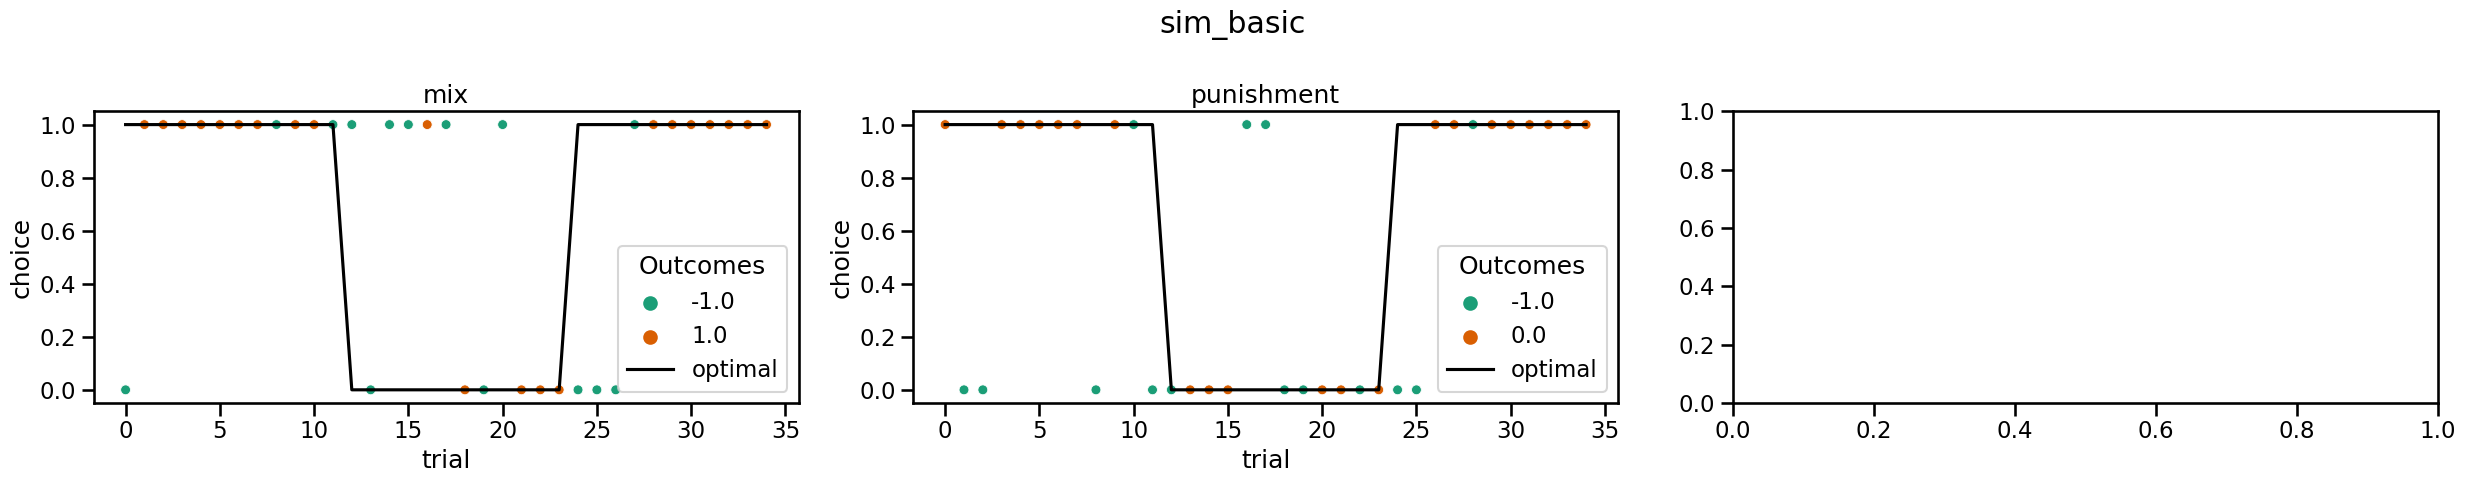

In [107]:
# pick 1 subject to visualize
sub1 = matching_reversal[matching_reversal['subject']==0]
plot_outcome_scatter(matching_reversal)